# Assignment 5: Classification Showdown

Build and compare classification models on the Fashion-MNIST dataset.

## Setup

In [5]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from xgboost import XGBClassifier

from helpers import load_fashion_mnist, plot_roc_curves, plot_confusion_matrix

# Create output directory
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete!")

Setup complete!


---

## Part 1: Binary Classification

**Task:** Classify T-shirts (label 0) vs Trousers (label 1)

This is a straightforward binary classification task. Focus on:
- Filtering data to the target classes
- Proper train/test splitting with stratification
- Scaling features correctly (fit on train only!)

In [6]:
print("Part 1: Binary Classification")
print("-" * 40)

# Load the full dataset
X, y = load_fashion_mnist()

# Filter to only labels 0 and 1
# Hint: np.isin(y, [0, 1]) returns a boolean array where True means the label is 0 or 1
# Use this mask to index into X and y: X[mask], y[mask]
mask = np.isin(y, [0, 1])
X_filtered = X[mask] 
y_filtered = y[mask]

# Train/test split with stratification
# Use test_size=0.2, random_state=42, stratify=y_filtered
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size = 0.2, random_state= 42, stratify=y_filtered)  # TODO

# Scale features - fit on train, transform both
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)   # TODO: transform X_test (not fit_transform!)

# Train LogisticRegression (use max_iter=1000, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)
# TODO: fit the model

# Evaluate
y_pred = model.predict(X_test_scaled) # TODO: predict on X_test_scaled
accuracy = accuracy_score(y_test, y_pred)  # TODO: calculate accuracy_score
cm = confusion_matrix(y_test, y_pred)  # TODO: calculate confusion_matrix

# Save results
results = {
    "task": "tshirt_vs_trouser",
    "accuracy": accuracy,
    "confusion_matrix": cm.tolist()  # Convert numpy array to list for JSON
}
with open(os.path.join(OUTPUT_DIR, "part1_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{cm}")

Part 1: Binary Classification
----------------------------------------
Accuracy: 0.9836
Confusion Matrix:
[[1371   29]
 [  17 1383]]


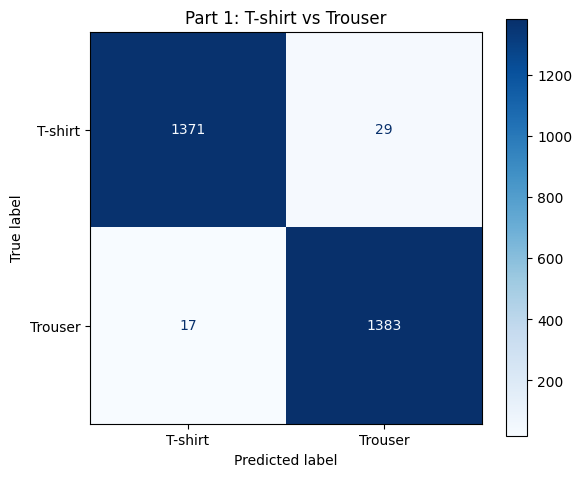

In [7]:
# Visualize results (provided - not part of assignment)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['T-shirt', 'Trouser']).plot(ax=ax, cmap='Blues')
ax.set_title('Part 1: T-shirt vs Trouser')
plt.tight_layout()
plt.show()

---

## Part 2: Multi-class Classification with Cross-Validation

**Task:** Classify footwear types: Sandal (5) vs Sneaker (7) vs Ankle boot (9)

Compare three models using 5-fold cross-validation. Select the best model and evaluate on test set.

**Required outputs:**
- `output/part2_cv_results.csv` - columns: `model`, `fold`, `score`
- `output/part2_test_results.csv` - classification report as DataFrame

In [9]:
print("\nPart 2: Multi-class Classification with CV")
print("-" * 40)

# TODO: Load data, filter to labels 5, 7, 9
# TODO: Encode labels to 0, 1, 2 using LabelEncoder (required for XGBoost)
# TODO: Train/test split with stratification
# TODO: Scale features

#load data
X, y = load_fashion_mnist()
mask = np.isin(y, [5, 7, 9])
X_filtered = X[mask]
y_filtered = y[mask]
le = LabelEncoder()
y_filtered = le.fit_transform(y_filtered)
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
}

# TODO: Run 5-fold CV for each model (use StratifiedKFold, scoring='accuracy')
# TODO: Save CV results to part2_cv_results.csv
# TODO: Find best model by mean CV score
# TODO: Retrain best model on full training data
# TODO: Evaluate on test set, save classification_report to part2_test_results.csv


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    print(f"{name} CV Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    # Save fold-level scores
    for fold_idx, score in enumerate(scores):
        cv_results.append({
            "model": name,
            "fold": fold_idx,
            "score": score
        })
cv_df = pd.DataFrame(cv_results)
cv_df.to_csv(os.path.join(OUTPUT_DIR, "part2_cv_results.csv"), index=False)

mean_scores = cv_df.groupby("model")["score"].mean()
best_model_name = mean_scores.idxmax()
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
report = classification_report(
    y_test,
    y_pred,
    target_names = [str(x) for x in le.inverse_transform([0, 1, 2])],
    output_dict=True
)
print("Test Classification Report:")
print(pd.DataFrame(report).transpose())
test_df = pd.DataFrame(report).transpose()
test_df.to_csv(os.path.join(OUTPUT_DIR, "part2_test_results.csv"))


Part 2: Multi-class Classification with CV
----------------------------------------
LogisticRegression CV Accuracy: 0.9279 ± 0.0062
RandomForest CV Accuracy: 0.9524 ± 0.0039
XGBoost CV Accuracy: 0.9670 ± 0.0033
Best model: XGBoost
Test Classification Report:
              precision    recall  f1-score      support
5              0.983465  0.977143  0.980294  1400.000000
7              0.952113  0.965714  0.958865  1400.000000
9              0.969042  0.961429  0.965221  1400.000000
accuracy       0.968095  0.968095  0.968095     0.968095
macro avg      0.968207  0.968095  0.968127  4200.000000
weighted avg   0.968207  0.968095  0.968127  4200.000000


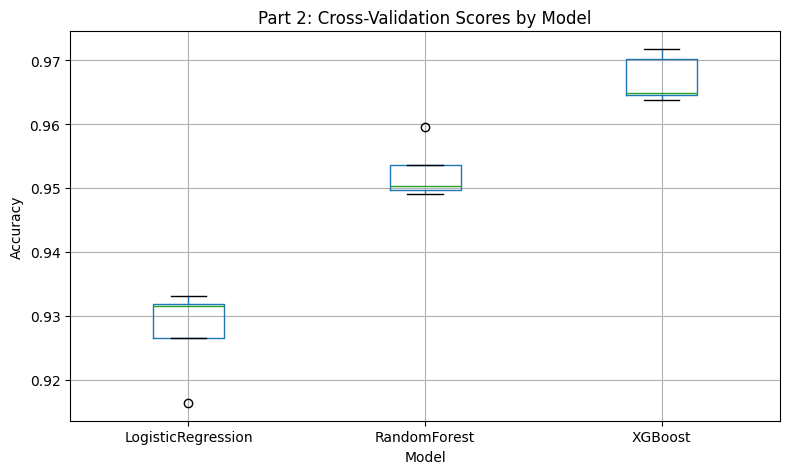

In [10]:
# Visualize CV results (provided - not part of assignment)
import matplotlib.pyplot as plt

try:
    fig, ax = plt.subplots(figsize=(8, 5))
    cv_df.boxplot(column='score', by='model', ax=ax)
    ax.set_title('Part 2: Cross-Validation Scores by Model')
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    plt.suptitle('')  # Remove automatic title
    plt.tight_layout()
    plt.show()
except NameError:
    print("cv_df not defined yet - complete the TODOs above first!")

---

## Part 3: Full Model Comparison Pipeline

**Task:** Classify Clothing vs Footwear (binary)

- **Clothing (0):** T-shirt, Trouser, Pullover, Dress, Coat, Shirt (labels 0-4, 6)
- **Footwear (1):** Sandal, Sneaker, Ankle boot (labels 5, 7, 9)
- **Exclude:** Bag (label 8)

Compare 3 models using AUC, generate ROC curves, evaluate best model.

**Required outputs:**
- `output/part3_cv_results.csv` - columns: `model`, `fold`, `auc`
- `output/part3_test_results.csv` - columns: `model`, `accuracy`, `auc`
- `output/part3_roc_curves.png` - use `plot_roc_curves()` from helpers
- `output/part3_confusion_matrix.png` - use `plot_confusion_matrix()` from helpers

In [14]:
print("\nPart 3: Full Model Comparison Pipeline")
print("-" * 40)

# TODO: Load data, filter out bags (label 8)
# TODO: Create binary labels: footwear (5, 7, 9) = 1, clothing = 0
# TODO: Train/test split with stratification
# TODO: Scale features

X, y = load_fashion_mnist()
mask = y != 8
X_filtered = X[mask]
y_filtered = y[mask]
y_binary = np.isin(y_filtered, [5, 7, 9]).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_binary, test_size=0.2, random_state=42, stratify=y_binary)    
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
}

# TODO: Run 5-fold CV for all models (use StratifiedKFold, scoring='roc_auc')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    
    print(f"{name} CV AUC: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    # Save fold-level scores
    for fold_idx, score in enumerate(scores):
        cv_results.append({
            "model": name,
            "fold": fold_idx,
            "auc": score
        })
# TODO: Save CV results to part3_cv_results.csv
cv_df = pd.DataFrame(cv_results)
cv_df.to_csv(os.path.join(OUTPUT_DIR, "part3_cv_results.csv"), index=False)

# TODO: Find best model by mean AUC
mean_scores = cv_df.groupby("model")["auc"].mean()
best_model_name = mean_scores.idxmax()
print(f"Best model: {best_model_name}")

# TODO: Train ALL models on full training data (needed for ROC curves)
for name, model in models.items():
    model.fit(X_train, y_train)

# TODO: Generate ROC curves: plot_roc_curves(trained_models, X_test_scaled, y_test, save_path)
plot_roc_curves(models, X_test, y_test, os.path.join(OUTPUT_DIR, "part3_roc_curves.png"))

# TODO: Evaluate best model on test set (accuracy and AUC)
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Best model test accuracy: {accuracy:.4f}")
print(f"Best model test AUC: {auc:.4f}")

# TODO: Generate confusion matrix: plot_confusion_matrix(y_test, y_pred, ['Clothing', 'Footwear'], save_path)
plot_confusion_matrix(y_test, y_pred, ['Clothing', 'Footwear'], os.path.join(OUTPUT_DIR, "part3_confusion_matrix.png"))

# TODO: Save test results to part3_test_results.csv
test_results = {
    "model": best_model_name,
    "accuracy": accuracy,
    "auc": auc
}
test_df = pd.DataFrame([test_results])
test_df.to_csv(os.path.join(OUTPUT_DIR, "part3_test_results.csv"), index=False)


Part 3: Full Model Comparison Pipeline
----------------------------------------
LogisticRegression CV AUC: 0.9997 ± 0.0001
RandomForest CV AUC: 1.0000 ± 0.0000
XGBoost CV AUC: 1.0000 ± 0.0000
Best model: XGBoost
Best model test accuracy: 0.9994
Best model test AUC: 1.0000


---

## Validation

In [12]:
# Run in terminal: pytest .github/tests/ -v
print("Run 'pytest .github/tests/ -v' in your terminal to check your work.")

Run 'pytest .github/tests/ -v' in your terminal to check your work.
